In [52]:
from helper import *
sys.path.insert(0,'tods') 
import plotter as pltr

In [53]:
# Hyper-parameters
window_size = 50
step_size = int(0.1 * window_size)
detector = 'DeepLog'
dataset = 'SMD'

## Step 1. Load Dataset

In [54]:
if dataset == 'SMD':
    GROUP = 1
    ENTITY = 2
    SMD_BASE_PATH = 'Dataset/SMD'

    X_train = load_data('%s/train/machine-%d-%d.txt' % (SMD_BASE_PATH, GROUP, ENTITY), header=False)
    X_train.columns = ['m%d' % i for i in range(X_train.shape[1])]
    X_train.index = pd.date_range('2021/03/02', '2021/03/21', periods=X_train.shape[0])
    X_train.index.name = 'timestamp'

    X_test = load_data('%s/test/machine-%d-%d.txt' % (SMD_BASE_PATH, GROUP, ENTITY), header=False)
    X_test.columns = ['m%d' % i for i in range(X_test.shape[1])]
    X_test.index = pd.date_range('2021/03/21', '2021/4/8', periods=X_test.shape[0])
    X_test.index.name = 'timestamp'

    y_true = pd.read_csv('Dataset/SMD/test_label/machine-%d-%d.txt' % (GROUP, ENTITY), header=None)
    y_true.columns = ['label']
    y_true.index = X_test.index

In [55]:
if dataset == 'CTF':
    import pickle as pkl

    ENTITY = 0
    CTF_BASE_PATH = 'Dataset/CTF/processed'

    X_train = load_data('%s/train/%d.csv' % (CTF_BASE_PATH, ENTITY)).iloc[:-1]
    X_train.columns = ['m%d' % i for i in range(X_train.shape[1])]
    X_train.index = pd.date_range(start='2020/04/18', freq='30s', periods=X_train.shape[0])
    X_train.index.name = 'timestamp'

    X_test = load_data('%s/test/%d.csv' % (CTF_BASE_PATH, ENTITY)).iloc[:-1]
    X_test.columns = ['m%d' % i for i in range(X_test.shape[1])]
    X_test.index = pd.date_range(start='2020/04/23', freq='30s', periods=X_test.shape[0])
    X_test.index.name = 'timestamp'

    with open('Dataset/CTF/label_result/%d.pkl' % ENTITY, 'rb') as f:
        y = pd.DataFrame(pkl.load(f), columns=['label'])
        y.index = X_test.index

In [56]:
print('Train Shape:', X_train.shape)
print('Test Shape:', X_test.shape)

Train Shape: (23694, 37)
Test Shape: (23694, 37)


In [57]:
# plot the first dimension
pltr.plot_data(pd.concat([X_train, X_test], axis=0), 'm0')

In [58]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_true = y_true.to_numpy()
print("window size:", window_size)

window size: 50


## Step 3. Anomaly Detection

In [59]:
import sys
import argparse
import os
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn import metrics

In [60]:
if detector == 'DeepLog':
    from tods.sk_interface.detection_algorithm.DeepLog_skinterface import DeepLogSKI

    transformer = DeepLogSKI(window_size=window_size, step_size=step_size, features=X_train.shape[1], validation_size=0.1, hidden_size=4, preprocessing=False, verbose=1, batch_size=32, epochs=10, stacked_layers=4)
    transformer.fit(X_train)
elif detector == 'LSTM':
    from tods.sk_interface.detection_algorithm.LSTMODetector_skinterface import LSTMODetectorSKI

    transformer = LSTMODetectorSKI(window_size=window_size, step_size=step_size, feature_dim=X_train.shape[1], hidden_dim=4, batch_size=32, epochs=10, activation='sigmoid', n_hidden_layer=4)
    transformer.fit(X_train)
elif detector == 'Telemanom':
    from tods.sk_interface.detection_algorithm.Telemanom_skinterface import TelemanomSKI

    transformer = TelemanomSKI(l_s=window_size, n_predictions=step_size, epochs=10, batch_size=32, layers=[16, 16])
    transformer.fit(X_train)
elif detector == 'KDiscord':
    from tods.sk_interface.detection_algorithm.KDiscordODetector_skinterface import KDiscordODetectorSKI

    transformer = KDiscordODetectorSKI(window_size=window_size, step_size=step_size)
    transformer.fit(X_train)

Epoch 1/10
665/665 [==============================] - 74s 112ms/step - loss: 0.0056 - val_loss: 0.0043
Epoch 2/10
665/665 [==============================] - 70s 106ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 3/10
665/665 [==============================] - 71s 107ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 4/10
665/665 [==============================] - 72s 109ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 5/10
665/665 [==============================] - 71s 107ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 6/10
665/665 [==============================] - 72s 109ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 7/10
665/665 [==============================] - 70s 105ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 8/10
665/665 [==============================] - 70s 106ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 9/10
665/665 [==============================] - 71s 107ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 10/10
665/665 [==============================] - 70s 106ms/step - l

In [61]:
transformer.primitives

[d3m.primitives.tods.detection_algorithm.deeplog(hyperparams=Hyperparams({'contamination': 0.1, 'window_size': 50, 'step_size': 5, 'return_subseq_inds': False, 'use_columns': (), 'exclude_columns': (), 'return_result': 'new', 'use_semantic_types': False, 'add_index_columns': False, 'error_on_no_input': True, 'return_semantic_type': 'https://metadata.datadrivendiscovery.org/types/Attribute', 'hidden_size': 4, 'loss': 'mean_squared_error', 'optimizer': 'Adam', 'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.2, 'l2_regularizer': 0.1, 'validation_size': 0.1, 'features': 37, 'stacked_layers': 4, 'preprocessing': False, 'verbose': 1}), random_seed=0)]

In [62]:
for primitive in transformer.primitives:
    try:
        print(primitive._clf._model.model.summary())
    except:
        print(primitive._clf.model_.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 50, 4)             672       
_________________________________________________________________
lstm_11 (LSTM)               (None, 50, 4)             144       
_________________________________________________________________
lstm_12 (LSTM)               (None, 50, 4)             144       
_________________________________________________________________
lstm_13 (LSTM)               (None, 50, 4)             144       
_________________________________________________________________
lstm_14 (LSTM)               (None, 4)                 144       
_________________________________________________________________
dense_2 (Dense)              (None, 37)                185       
Total params: 1,433
Trainable params: 1,433
Non-trainable params: 0
____________________________________________________

In [63]:
for primitive in transformer.primitives:
    pred_score = primitive._clf.decision_function(X_test)
    pred_score_train = primitive._clf.decision_scores_

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.



In [64]:
if type(pred_score) is tuple:
    pred_score = pred_score[0]

In [65]:
import plotly.graph_objects as go

## Plot decision scores
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(X_test)), y=pred_score, mode='lines', name='anomaly_score'))
fig.update_layout(height=400, width=800, showlegend=True)
fig.show()

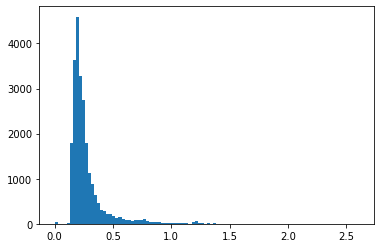

In [66]:
plt.hist(pred_score, bins=100)
plt.show()

## Step 4. Label Anomalies on the Test Dataset

In [67]:
if detector == 'Telemanom':
    y_pred = transformer.predict(X_test)
else:
    mu = pred_score.mean()
    sigma = pred_score.std()
    threshold = mu + 3*sigma
    y_pred = pred_score > threshold

In [68]:
# pred_score_temp = []
# i = 0
# while i + step_size < len(pred_score):
#     pred_score_temp.append(pred_score[i:i+step_size])
#     i += step_size
# y_pred = label_anomalies_2(pred_score_temp, y_true, window_size, step_size, 3, eval_opt='contextual')

In [69]:
x_test = pd.DataFrame(X_test)
pred_anomalies = pd.DataFrame(x_test.loc[np.where(y_pred == 1)[0]])

col = 0
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_test.index, y=x_test[col], mode='lines', name='x_test'))
fig.add_trace(go.Scatter(x=pred_anomalies.index, y=pred_anomalies[col], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, xaxis_title="Time", yaxis_title="value", height=400, width=800)
fig.show()

In [70]:
real_anomalies = pd.DataFrame(x_test.iloc[np.where(y_true == 1)[0]])

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_test.index, y=x_test[col], mode='lines', name='x_test'))
fig.add_trace(go.Scatter(x=real_anomalies.index, y=real_anomalies[col], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, xaxis_title="Time", yaxis_title="value", height=400, width=800)
fig.show()

## Step 5. Evaluate Results

In [71]:
y_true = y_true[:len(y_pred)]

In [72]:
print('Accuracy Score: ', accuracy_score(y_true, y_pred))

Accuracy Score:  0.972946737570693


In [73]:
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
f1_scores = 2*recall*precision/(recall+precision)
fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

In [74]:
tn, fp, fn, tp  =  confusion_matrix(y_true, y_pred).ravel()
print('TN:', tn)
print('FP:', fp)
print('FN:', fn)
print('TP:', tp)

TN: 22809
FP: 343
FN: 298
TP: 244


In [75]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23152
           1       0.42      0.45      0.43       542

    accuracy                           0.97     23694
   macro avg       0.70      0.72      0.71     23694
weighted avg       0.97      0.97      0.97     23694



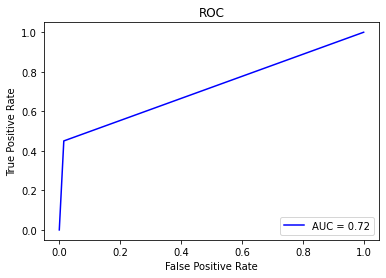

In [76]:
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()